# Rescalling image

Our images have resolution 2500x2500, in the CLOOME they have used images with resolution 520x520.
In order to test if features extracted from images of the same size preprocessing is needed :

    1. block mean downsampling 
    2. interpolation

In [1]:
import numpy as np
import os

In [6]:
import torch
import multiprocessing as mp
from functools import partial

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cuda


## Block mean downsampling image

In [2]:
input_dir = '/share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz'
output_dir = '/share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_500p/channels_tiff_npz'  
os.makedirs(output_dir, exist_ok=True)

In [22]:
def block_mean_downsampling_GPU(npz_file_path, output_dir, block_size):
    npz_data = np.load(npz_file_path, allow_pickle=True)
    
    sample = npz_data['sample']
    channels = npz_data['channels'].item()
    filenames = npz_data['filenames'].item()
    
    img_height, img_width, num_channels = sample.shape  

    if img_height % block_size != 0 or img_width % block_size != 0:
        raise ValueError(f"Image dimensions ({img_height}, {img_width}) are not divisible by the block size {block_size}!")

    new_height = img_height // block_size
    new_width = img_width // block_size

    sample_tensor = torch.from_numpy(sample).float().cuda() 
    img_downsampled = torch.zeros((new_height, new_width, num_channels), device='cuda')

    for c in range(num_channels):
        for i in range(0, img_height, block_size):
            for j in range(0, img_width, block_size):
                block = sample_tensor[i:i+block_size, j:j+block_size, c]
                img_downsampled[i // block_size, j // block_size, c] = torch.mean(block)

    img_downsampled_cpu = img_downsampled.cpu().numpy()

    base_name = os.path.basename(npz_file_path)
    file_path = os.path.join(output_dir, base_name)
    
    np.savez(file_path, sample=img_downsampled_cpu, channels=channels, filenames=filenames)
    
    print(f"Downsampling and saving completed for {npz_file_path}.")

In [28]:
def process_images_in_parallel(npz_file_paths, output_dir, block_size, num_workers):
    with mp.Pool(processes=num_workers) as pool:
        process_image_partial = partial(block_mean_downsampling, output_dir=output_dir, block_size=block_size
        pool.map(process_image_partial, npz_file_paths)                    # Processing images in paralel

if __name__ == "__main__":
    input_dir = '/share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz'
    output_dir = '/share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_500p/channels_tiff_npz'  
    os.makedirs(output_dir, exist_ok=True)
    
    block_size = 5
    num_workers = mp.cpu_count()                                           # In order to use all available CPU cores
    print(f"Number of workers : {num_workers}")

    npz_file_paths = [os.path.join(input_dir, f) for f in os.listdir(input_dir) if f.endswith('.npz')]

    process_images_in_parallel(npz_file_paths, output_dir, block_size, num_workers)


Number of workers : 48
Splitting and saving completed for /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-D22-3.npz.
Splitting and saving completed for /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-D15-9.npz.
Splitting and saving completed for /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-K19-8.npz.
Splitting and saving completed for /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-A10-7.npz.
Splitting and saving completed for /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-P11-6.npz.
Splitting and saving completed for /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz/P102785-D04-1.npz.
Splitting and saving completed for /share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all

In [45]:
npz_file_paths_a = [f for f in os.listdir('/share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_DMSO_npz') if f.endswith('.npz')]
npz_file_paths_d = [f for f in os.listdir('/share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/channels_tiff_npz') if f.endswith('.npz')]

intersect = [x for x in npz_file_paths_a if x in npz_file_paths_d]

intersect_well = list(set([x.split("-")[1] for x in intersect]))

intersect_well.sort()

print(intersect_well)

['A02', 'A19', 'B07', 'C10', 'C15', 'D23', 'E06', 'F03', 'F14', 'G11', 'G22', 'H18', 'I08', 'J12', 'J24', 'K01', 'K17', 'L05', 'L20', 'M09', 'M13', 'N16', 'O21', 'P04']


In [51]:
import pandas as pd
df = pd.read_csv('/share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_all/metadata_P102785_ALL.csv')
print(df['WELL_POSITION'])

0       A02
1       A02
2       A02
3       A02
4       A02
       ... 
2596    P23
2597    P23
2598    P23
2599    P23
2600    P23
Name: WELL_POSITION, Length: 2601, dtype: object


### No GPU

In [13]:
def block_mean_downsampling(npz_file_path, output_dir, block_size):
    npz_data = np.load(npz_file_path, allow_pickle=True)
    
    sample = npz_data['sample']                   
    channels = npz_data['channels'].item()  
    filenames = npz_data['filenames'].item()
    
    img_height, img_width, num_channels = sample.shape 

    if img_height % block_size != 0 or img_width % block_size != 0:
        raise ValueError(f"Image dimensions ({img_height}, {img_width}) are not divisible by the block size {block_size}!")

    new_height = img_height // block_size
    new_width = img_width // block_size
   # print(f"Downsizing from ({img_height}, {img_width}) to ({new_height}, {new_width}).")
    
    img_downsampled = np.zeros((new_height, new_width, num_channels), dtype=sample.dtype)

    for c in range(num_channels):
        for i in range(0, img_height, block_size):
            for j in range(0, img_width, block_size):
                block = sample[i:i+block_size, j:j+block_size, c]
                img_downsampled[i // block_size, j // block_size, c] = np.mean(block)
                
    base_name = os.path.basename(npz_file_path)
    file_path = os.path.join(output_dir, base_name)
   # print(file_path)
            
    np.savez(file_path, sample=img_downsampled, channels=channels, filenames=filenames)
    
    print(f"Splitting and saving completed for {npz_file_path}.")
    

In [ ]:
npz_files = [f for f in os.listdir(input_dir) if f.endswith('.npz')]

for npz_file in npz_files:
    path = input_dir + "/" + npz_file
    #print(path)
    block_mean_downsampling_GPU(path, output_dir, 5)

### Testing for one image

In [24]:
import numpy as np

data = np.load('/share/data/analyses/silvija/RT/data_cloome/our_images/preprocessing_500p/channels_tiff_npz/P102785-A03-2.npz', allow_pickle=True)

print(data.files)

for key in data.files:
    print(f"{key}: {data[key]}")


['sample', 'channels', 'filenames']
sample: [[[ 97.479996  115.04       82.4        44.48       39.16     ]
  [145.8       161.04       93.24       51.96       42.719997 ]
  [160.68      191.84       99.84       58.92       48.76     ]
  ...
  [  2.3999999   2.84       14.2        24.6         3.6799998]
  [  2.44        2.6399999  13.799999   24.08        3.28     ]
  [  2.12        2.8        13.679999   24.24        3.36     ]]

 [[ 75.6       105.88       76.6        42.6        37.879997 ]
  [128.68      148.48       90.119995   51.399998   44.44     ]
  [152.76      181.64      100.28       59.92       54.079998 ]
  ...
  [  2.2         2.8        13.719999   24.6         3.36     ]
  [  2.32        2.8799999  13.759999   23.96        3.36     ]
  [  2.36        2.76       14.         24.279999    3.28     ]]

 [[ 47.76       75.2        64.56       38.28       35.16     ]
  [ 99.68      125.92       81.439995   49.52       46.96     ]
  [134.04      166.12       95.799995   60.1

In [25]:
sample = data['sample']
channels = data['channels']
filenames = data['filenames']

print("Sample shape:", sample.shape)
print("Channels:", channels)
print("Filenames:", filenames)


Sample shape: (500, 500, 5)
Channels: {0: '405', 1: '488', 2: '561', 3: '638', 4: '730'}
Filenames: {'405': 'P102785_A03_s2_x1_y0_Fluorescence_405_nm_Ex', '488': 'P102785_A03_s2_x1_y0_Fluorescence_488_nm_Ex', '561': 'P102785_A03_s2_x1_y0_Fluorescence_561_nm_Ex', '638': 'P102785_A03_s2_x1_y0_Fluorescence_638_nm_Ex', '730': 'P102785_A03_s2_x1_y0_Fluorescence_730_nm_Ex'}


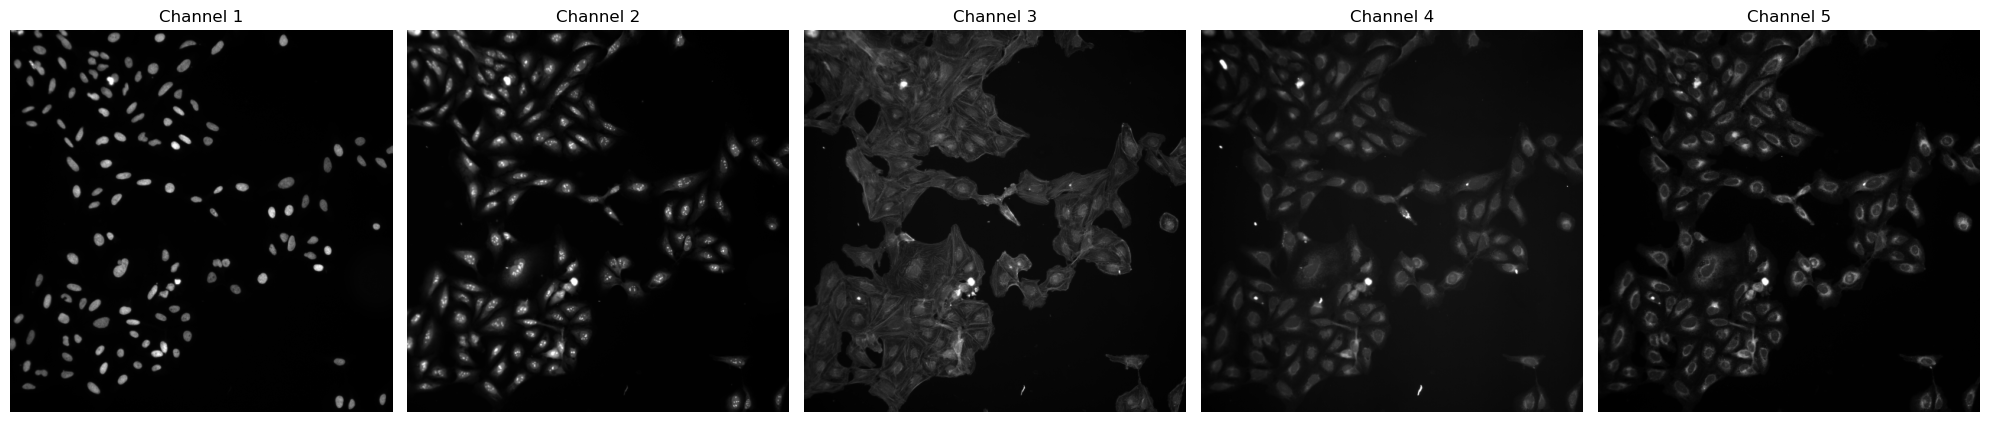

In [26]:
fig, axes = plt.subplots(1, num_channels, figsize=(20, 5))

for channel in range(num_channels):
    axes[channel].imshow(sample[:, :, channel], cmap='gray')
    axes[channel].set_title(f'Channel {channel + 1}')
    axes[channel].axis('off')

plt.tight_layout()
plt.show()

## Interpolation